<a href="https://colab.research.google.com/github/svenkatlata/Melanoma-Skin-Cancer-Detection-CNN-Model/blob/main/Venkat_Lata_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Skin cancer is one of the most common forms of cancer worldwide, with melanoma being its most aggressive and life-threatening type. Early detection is crucial, as it significantly improves survival rates and treatment outcomes. Melanoma arises from melanocytes, the cells responsible for producing pigment in the skin. Although it accounts for only a small fraction of skin cancer cases, it is responsible for 75% of skin cancer-related deaths, underscoring the critical need for timely diagnosis and treatment.

## Background

Traditional methods for melanoma diagnosis involve visual inspections by dermatologists and the use of dermoscopy tools. While these methods are effective, they require specialized expertise and can be time-consuming. With advancements in medical imaging and machine learning, artificial intelligence (AI) presents an opportunity to augment dermatological diagnostics by providing automated, accurate, and fast detection of melanoma. A well-trained AI system can assist healthcare professionals by evaluating skin lesion images and flagging potentially cancerous cases for further analysis, thereby reducing the workload and improving diagnostic accuracy.

## Problem Statement

The goal of this project is to develop a **multiclass classification model using a custom convolutional neural network (CNN) in TensorFlow** that can accurately detect melanoma from images of skin lesions. Given the high mortality rate associated with melanoma, an automated detection system can play a crucial role in early diagnosis and treatment. By leveraging deep learning, this solution aims to minimize the manual effort required by dermatologists and ensure consistent, reliable evaluations of skin lesion images. The proposed system will act as a decision-support tool, helping to identify melanoma cases efficiently and potentially saving lives.

## Dataset

The dataset used in this project consists of **2,357 images** representing both malignant and benign oncological diseases. It is derived from the **International Skin Imaging Collaboration (ISIC)**, a widely recognized source of dermatological imaging data. The dataset is meticulously organized according to the ISIC classification system, ensuring consistency and reliability for training and evaluation.

The images are divided into subsets with an approximately equal distribution, except for melanomas and moles, which are slightly more prevalent. This reflects the practical scenario where certain conditions may occur more frequently.

The dataset includes the following skin conditions:  

#### **Pre-Malignant Disease**
1. **Actinic Keratosis:** A precancerous, rough, scaly skin patch from sun damage.

#### **Malignant Diseases**
1. **Basal Cell Carcinoma (BCC):** A slow-growing skin cancer from basal cells.  
2. **Squamous Cell Carcinoma (SCC):** A potentially invasive cancer from squamous cells.  
3. **Melanoma:** The most aggressive skin cancer from pigment-producing cells.

#### **Benign Diseases**
1. **Dermatofibroma:** A harmless, firm skin growth, often on the legs.  
2. **Nevus (Mole):** A benign collection of melanocytes (pigment cells).  
3. **Pigmented Benign Keratosis:** Non-cancerous pigmented, rough skin patches.  
4. **Seborrheic Keratosis:** Waxy, raised, benign skin growths.  
5. **Vascular Lesion:** Non-cancerous blood vessel abnormalities.

This comprehensive dataset serves as the foundation for building and validating the CNN-based melanoma detection model, enabling it to learn from a diverse range of skin conditions and improving its accuracy and generalizability in real-world applications.

## Import all the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from pathlib import Path
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
print(tf.__version__)

2.17.1


In [3]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# import zipfile

# # Define the ZIP file path
# zip_file_path = '/content/gdrive/MyDrive/CNN_assignment.zip'
# output_folder = '/content/gdrive/MyDrive/Skin_Cancer_Dataset'

# # Create the output folder if it doesn't exist
# os.makedirs(output_folder, exist_ok=True)

# # Unzip the file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(output_folder)
#     print("Files extracted successfully!")

In [5]:
# Defining the path for train and test images
root_path = r'/content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration'
train_dir = Path(root_path + '/Train')
test_dir = Path(root_path + '/Test')

In [6]:
image_count_train = len(list(train_dir.glob('*/*.jpg')))
print("Number of training images:", image_count_train)
image_count_test = len(list(test_dir.glob('*/*.jpg')))
print("Number of testing images:", image_count_test)

Number of training images: 2239
Number of testing images: 118


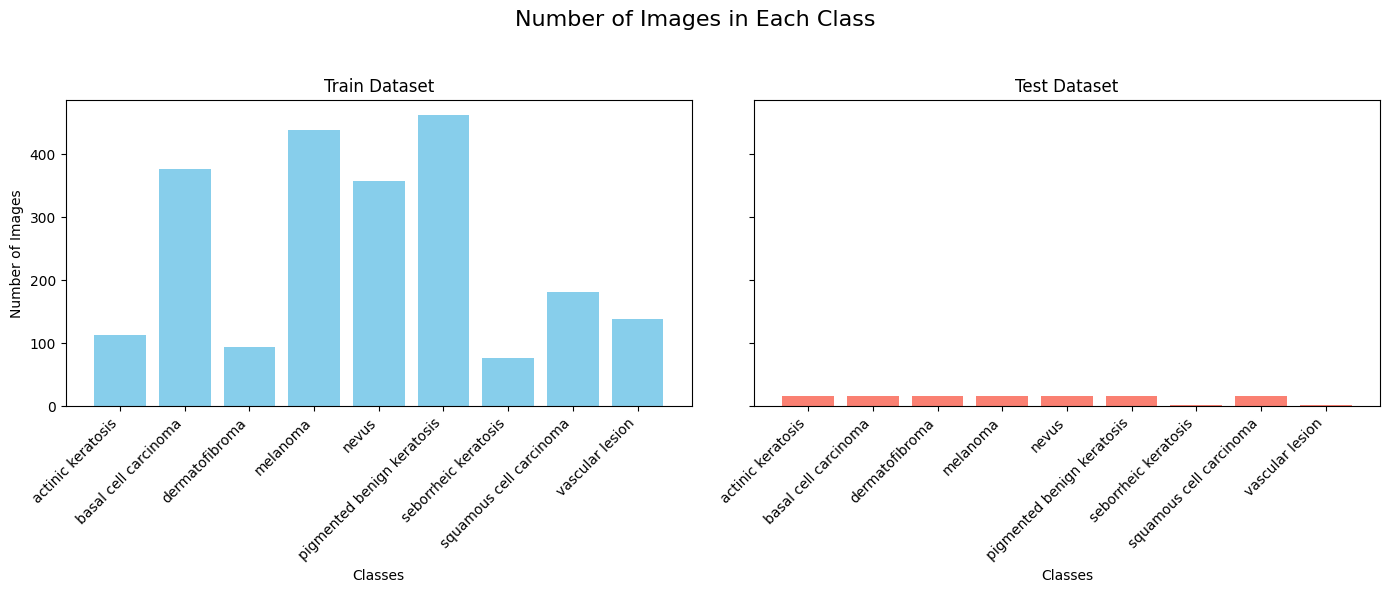

In [7]:
# Count images for the train dataset
train_counts = {}
for class_dir in train_dir.iterdir():
    if class_dir.is_dir():
        train_counts[class_dir.name] = len(list(class_dir.glob('*.jpg')))

# Count images for the test dataset
test_counts = {}
for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        test_counts[class_dir.name] = len(list(class_dir.glob('*.jpg')))

# Prepare data for plotting
train_classes = sorted(train_counts.keys())
train_values = [train_counts[cls] for cls in train_classes]

test_classes = sorted(test_counts.keys())
test_values = [test_counts[cls] for cls in test_classes]

# Plot the data
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
fig.suptitle("Number of Images in Each Class", fontsize=16)

# Train plot
axes[0].bar(train_classes, train_values, color='skyblue')
axes[0].set_title("Train Dataset")
axes[0].set_ylabel("Number of Images")
axes[0].set_xlabel("Classes")
axes[0].set_xticklabels(train_classes, rotation=45, ha="right")

# Test plot
axes[1].bar(test_classes, test_values, color='salmon')
axes[1].set_title("Test Dataset")
axes[1].set_xlabel("Classes")
axes[1].set_xticklabels(test_classes, rotation=45, ha="right")

# Show plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Base Model

Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
# Define image size and batch size
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
# Train Dataset
train_ds = keras.preprocessing.image_dataset_from_directory(
                  train_dir,
                  validation_split=0.2,
                  subset="training",
                  seed=123,
                  image_size=(img_height, img_width),
                  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
# Validation Dataset
val_ds = keras.preprocessing.image_dataset_from_directory(
                  train_dir,
                  validation_split=0.2,
                  subset="validation",
                  seed=123,
                  image_size=(img_height, img_width),
                  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List of all the classes of skin cancer and store them in a list
class_names = train_ds.class_names
print("Class Names:\n", class_names)

Class Names:
 ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data



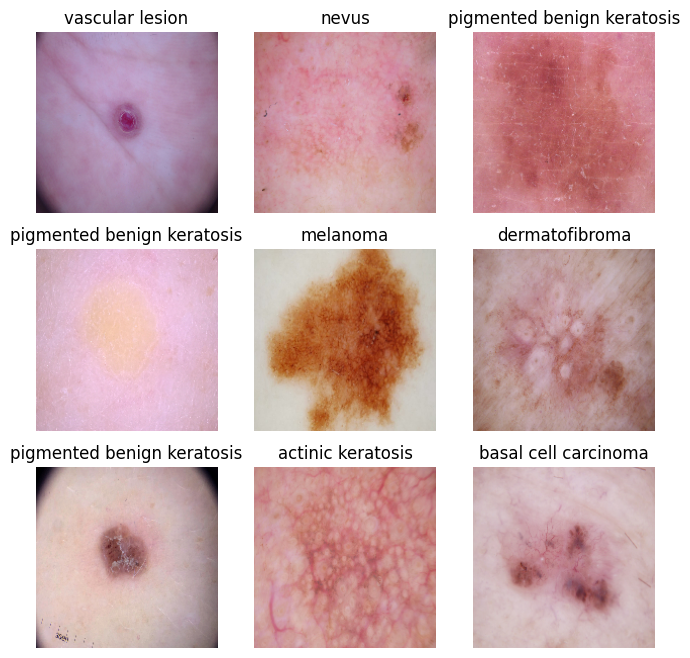

In [12]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):  # Take one batch from the dataset
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the Model

In [14]:
# CNN Architecture

model = Sequential()

# Normalization Layer
model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))

# First Convulation layer
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(64,kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(128,kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(128,kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(128,kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Flatten Layer
model.add(layers.Flatten())

# Fully Connected Dense Layer
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))

# Output Layer
model.add(layers.Dense(len(class_names), activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 45, 45, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 45, 45, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      63,439,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,286,761 (245.23 MB)

 Trainable params: 64,286,761 (245.23 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the Model

In [15]:
# Compile the Model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 247ms/step - accuracy: 0.1872 - loss: 2.1013 - val_accuracy: 0.2506 - val_loss: 2.0106
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2847 - loss: 1.9565 - val_accuracy: 0.4027 - val_loss: 1.7424
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3553 - loss: 1.8007 - val_accuracy: 0.4362 - val_loss: 1.6377
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3942 - loss: 1.6970 - val_accuracy: 0.4430 - val_loss: 1.6122
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4066 - loss: 1.6542 - val_accuracy: 0.4609 - val_loss: 1.5683
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4395 - loss: 1.6115 - val_accuracy: 0.4609 - val_loss: 1.5978
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4153 - loss: 1.6011 - val_accuracy: 0.4855 - val_loss: 1.5791
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4609 - loss: 1.5855 - val_accuracy: 0.5213 -

### Visualizing training results

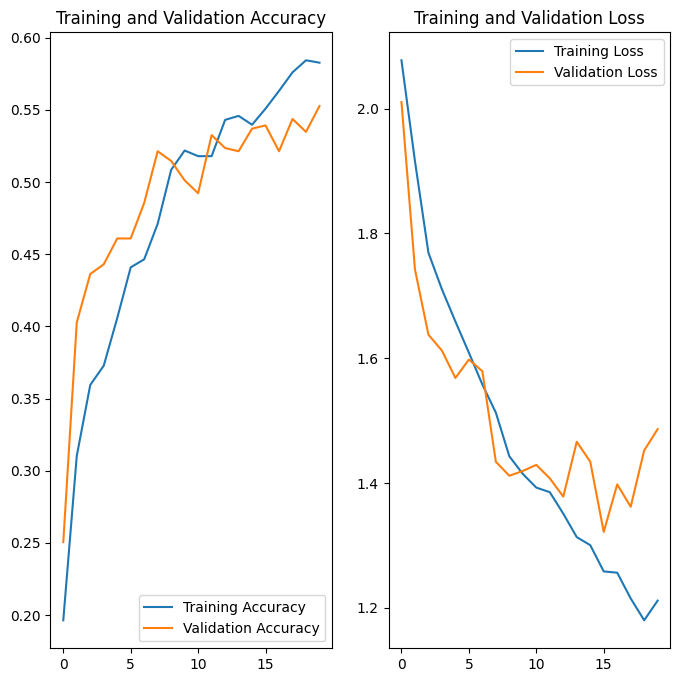

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Performance

In [18]:
loss, accuracy = model.evaluate(train_ds, verbose=1)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5935 - loss: 1.1227
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5952 - loss: 1.4004
Accuracy:  0.59765625
Validation Accuracy:  0.5525727272033691
Loss:  1.1039930582046509
Validation Loss 1.4863637685775757


### Findings

1. Low Training and Validation Accuracy: Requires more epochs
2. Considerable gap between training and validation performance: Appears to be Overfitted.
3. High Training Loss and Fluctuating Validation Loss.



## Data Augmentation

### Create the dataset

In [19]:
# Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
])

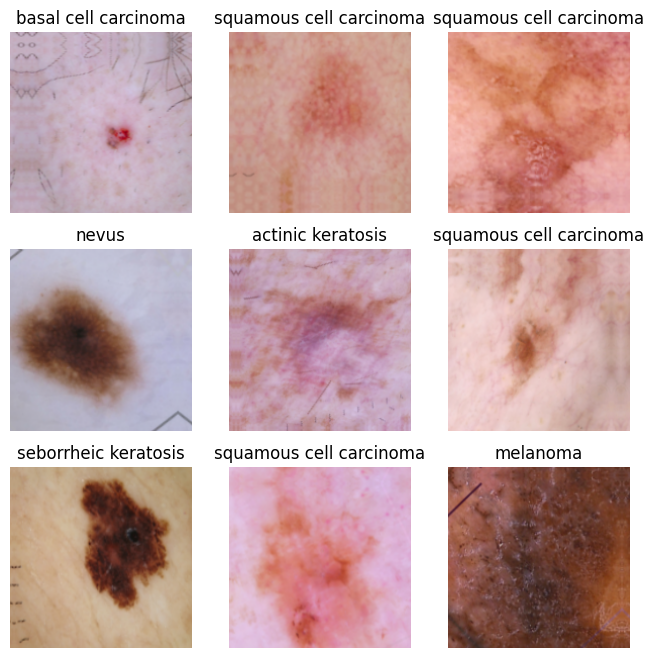

In [20]:
# Visualize the Augmented Dataset
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_image = data_augmentation(tf.expand_dims(images[i], 0))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Create the Model

In [21]:
# CNN Architecture

model = Sequential()

# Data Augmentation Layer
model.add(data_augmentation)

# Normalization Layer
model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))

# First Convulation layer
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Second Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(128,kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Third Convulation Layer
model.add(layers.Conv2D(256,kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(256,kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(256,kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(256,kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

# Fourth Convulation Layer
model.add(layers.Conv2D(512,kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(512,kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(512,kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(512,kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

# Flatten Layer
model.add(layers.Flatten())

# Fully Connected Dense Layer
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))

# Output Layer
model.add(layers.Dense(len(class_names), activation='softmax'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 74,289,737 (283.39 MB)

 Trainable params: 74,289,737 (283.39 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the Model

In [22]:
# Compile the Model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

### Train the Model

In [23]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - accuracy: 0.1684 - loss: 2.1323 - val_accuracy: 0.1924 - val_loss: 2.0517
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.1942 - loss: 2.0524 - val_accuracy: 0.1924 - val_loss: 2.0520
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.1881 - loss: 2.0430 - val_accuracy: 0.1924 - val_loss: 2.0297
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.2026 - loss: 2.0386 - val_accuracy: 0.2908 - val_loss: 2.0071
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.2204 - loss: 2.0123 - val_accuracy: 0.2528 - val_loss: 1.9310
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.3083 - loss: 1.8990 - val_accuracy: 0.3356 - val_loss: 1.8306
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.3136 - loss: 1.8046 - val_accuracy: 0.4072 - val_loss: 1.6453
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.3799 - loss: 1.7171 - val_accuracy: 0.4116 -

### Visualizing the results

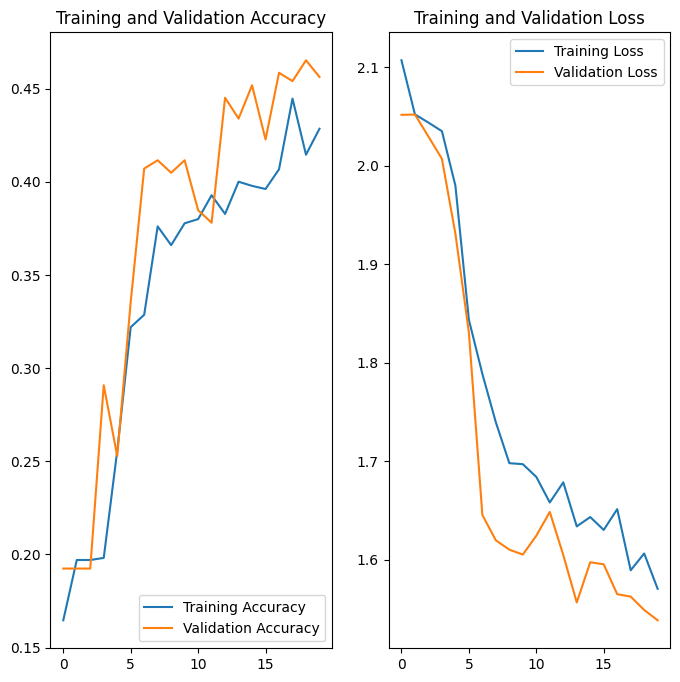

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Performance

In [25]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4641 - loss: 1.4782
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5049 - loss: 1.4669
Accuracy:  0.4704241156578064
Validation Accuracy:  0.4563758373260498
Loss:  1.4920036792755127
Validation Loss 1.5383106470108032


### Findings

1. Train Accuracy has not improved with Data Augmentation, probably due to Class Imabalance.
2.   Loss and Valudation Loss has decreased as compared to the previous model.
3. Small gap between Train and Validation Acuracy, indicating a good fit.



## Checking Class Imbalance


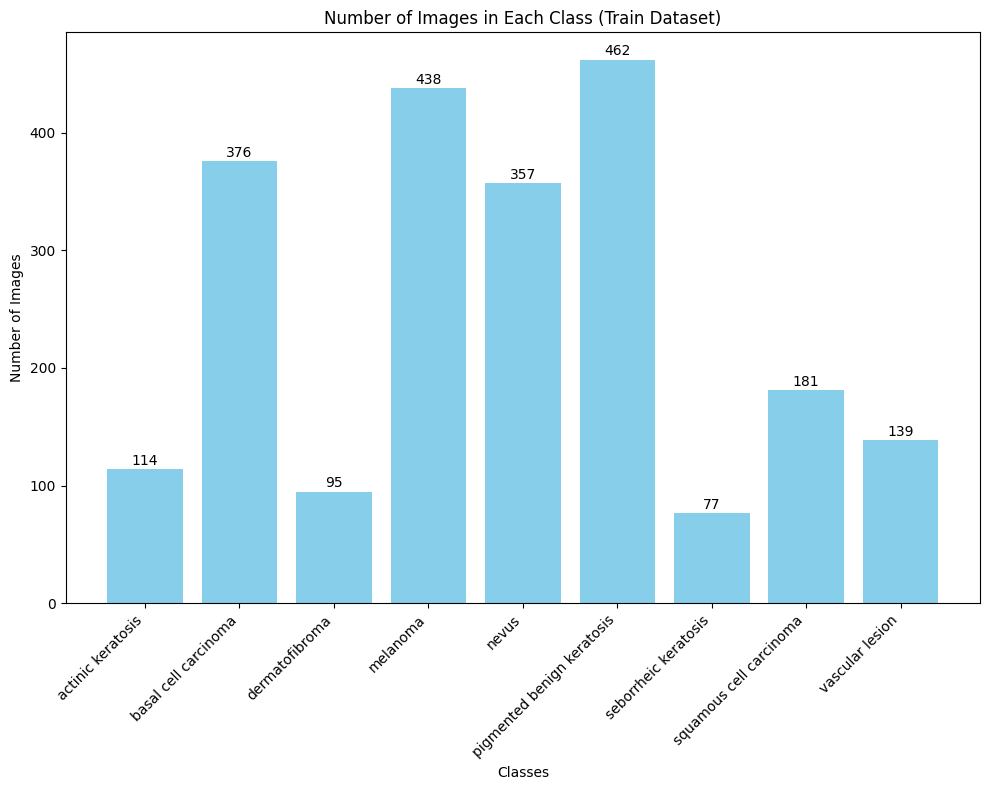

In [26]:
# Count images for the train dataset
train_counts = {}
for class_dir in train_dir.iterdir():
    if class_dir.is_dir():
        train_counts[class_dir.name] = len(list(class_dir.glob('*.jpg')))

# Prepare data for plotting
train_classes = sorted(train_counts.keys())
train_values = [train_counts[cls] for cls in train_classes]

# Plot the data (only for the train dataset)
plt.figure(figsize=(10, 8))
bars = plt.bar(train_classes, train_values, color='skyblue')

# Add counts on top of the bars
for bar, value in zip(bars, train_values):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 1, str(value),
             ha='center', va='bottom', fontsize=10)

plt.title("Number of Images in Each Class (Train Dataset)")
plt.ylabel("Number of Images")
plt.xlabel("Classes")
plt.xticks(rotation=45, ha="right")

# Show plot
plt.tight_layout()
plt.show()

### Findings



1.   Class with least no. of samples: `dermatofibroma` and `seborrheic keratosis`
2.   Dominant Class: `pigmented benign keratosis` and `melanoma`



### Rectifying the Class Imbalance using Augmentor library

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [27]:
!pip install Augmentor

In [28]:
import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(train_dir / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

    # Adding 500 samples per class to make sure that none of the classes are sparse.
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DD434115C30>: 100%|██████████| 500/500 [00:04<00:00, 101.95 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DD4342BEE60>: 100%|██████████| 500/500 [00:04<00:00, 103.74 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DD43414B1C0>: 100%|██████████| 500/500 [00:04<00:00, 105.21 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DD4341CB640>: 100%|██████████| 500/500 [00:16<00:00, 30.82 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2565x2000 at 0x7DD5110F0700>: 100%|██████████| 500/500 [00:11<00:00, 42.40 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DD510790340>: 100%|██████████| 500/500 [00:05<00:00, 99.24 Samples/s] 


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DD50468BEE0>: 100%|██████████| 500/500 [00:06<00:00, 74.09 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DD4347561A0>: 100%|██████████| 500/500 [00:04<00:00, 103.26 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DD5107CFF40>: 100%|██████████| 500/500 [00:05<00:00, 99.96 Samples/s] 


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
# Counting total number of image generated by Augmentor.
image_count_train = len(list(train_dir.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
from glob import glob

path_list_new = [x for x in glob(os.path.join(train_dir, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030036.jpg_cadb3fb5-5b6e-4ae1-b969-00ddbb7c81ee.jpg',
 '/content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026984.jpg_54d71d6a-2633-4f23-b70c-e69b13db74b4.jpg',
 '/content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_6f7dd266-28de-423f-acd8-a1e9c7ec5402.jpg',
 '/content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_0506d68b-092e-46dc-99e0-e7619e26d869.jpg',
 '/content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Co

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(train_dir, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [32]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [34]:
new_df['Label'].value_counts()

,count
Label,
actinic keratosis,500
basal cell carcinoma,500
dermatofibroma,500
melanoma,500
nevus,500
pigmented benign keratosis,500
seborrheic keratosis,500
squamous cell carcinoma,500
vascular lesion,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Final Model

### Create the dataset

In [35]:
batch_size = 32
img_height = 180
img_width = 180

In [36]:
# Train Dataset
train_ds = keras.preprocessing.image_dataset_from_directory(
                  train_dir,
                  validation_split=0.2,
                  subset="training",
                  seed=123,
                  image_size=(img_height, img_width),
                  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [37]:
# Validation Dataset
val_ds = keras.preprocessing.image_dataset_from_directory(
                  train_dir,
                  validation_split=0.2,
                  subset="validation",
                  seed=123,
                  image_size=(img_height, img_width),
                  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create the Model

In [38]:
# CNN Architecture

model = Sequential()

# Normalization Layer
model.add(layers.Rescaling(1./255, input_shape=(180,180,3)))

# First Convulation layer
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# Second Convulation Layer
model.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

# Third Convulation Layer
model.add(layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

# Fourth Convulation Layer
model.add(layers.Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

# Flatten Layer
model.add(layers.Flatten())

# Fully Connected Dense Layer
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))

# Output Layer
model.add(layers.Dense(len(class_names), activation='softmax'))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 268,804,681 (1.00 GB)

 Trainable params: 268,804,681 (1.00 GB)

 Non-trainable params: 0 (0.00 B)

### Compile the Model

In [39]:
# Compile the Model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

### Train the Model

In [40]:
epochs = 35
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 182ms/step - accuracy: 0.1408 - loss: 2.1892 - val_accuracy: 0.1403 - val_loss: 2.1885
Epoch 2/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.1426 - loss: 2.1799 - val_accuracy: 0.1403 - val_loss: 2.1909
Epoch 3/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.1264 - loss: 2.1826 - val_accuracy: 0.1403 - val_loss: 2.1930
Epoch 4/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.1581 - loss: 2.1429 - val_accuracy: 0.2732 - val_loss: 2.0078
Epoch 5/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.2217 - loss: 1.9879 - val_accuracy: 0.2947 - val_loss: 1.7611
Epoch 6/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.2699 - loss: 1.8234 - val_accuracy: 0.2880 - val_loss: 1.7595
Epoch 7/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.2757 - loss: 1.7576 - val_accuracy: 0.3467 - val_loss: 1.6979
Epoch 8/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.3542 - loss: 1.6640 -

### Visualizing the results

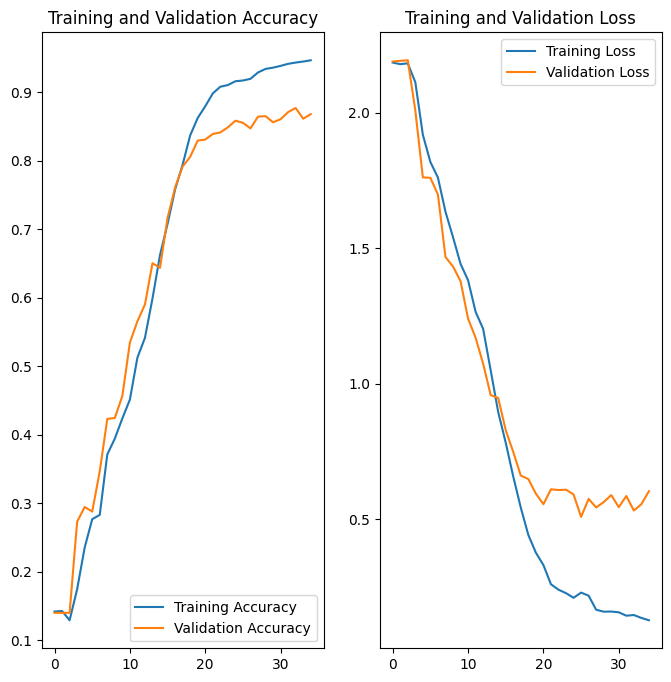

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Performance

In [42]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.9558 - loss: 0.0945
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8656 - loss: 0.5841
Accuracy:  0.9597551822662354
Validation Accuracy:  0.8678544759750366
Loss:  0.08783084899187088
Validation Loss 0.6034513711929321


### Findings

1. Slight Overfitting is observed.
2. Class Rebalance helped in improving Train and Validation Accuracy.
3. Loss and Validation Loss is very small.

## Model Predictions on the Test set

Selected Random Image: /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/squamous cell carcinoma/ISIC_0024522.jpg
Selected Random Image: /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/vascular lesion/ISIC_0024402.jpg
Selected Random Image: /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/squamous cell carcinoma/ISIC_0024575.jpg
Selected Random Image: /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000029.jpg
Selected Random Image: /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg
Selected Random Image: /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_000000

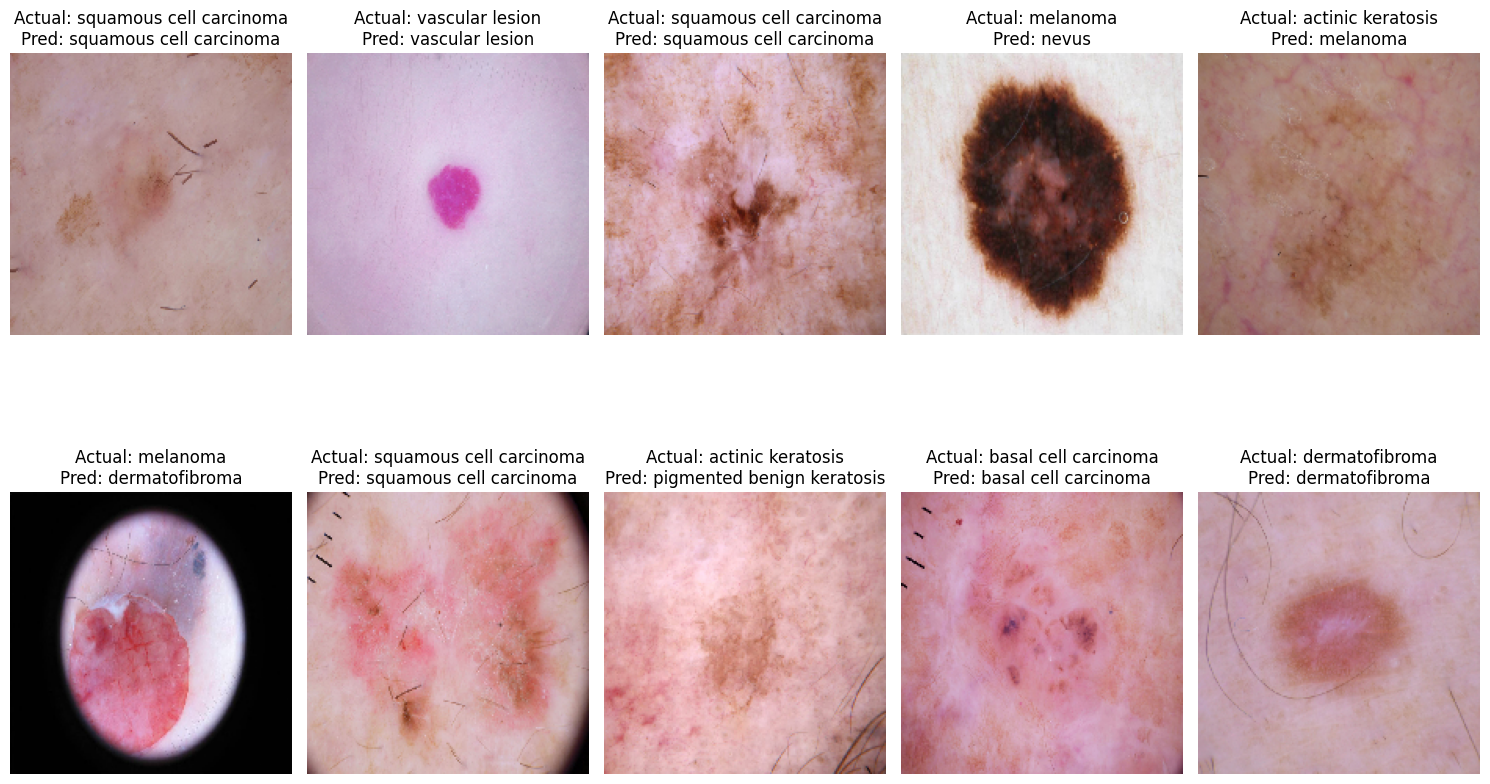

In [48]:
import random

# Path to test images
Test_image_path = os.path.join(test_dir, '*', '*')
Test_images = glob(Test_image_path)

# Set up a plot grid for 10 images
plt.figure(figsize=(15, 10))  # Adjust figure size
num_images = 10

for i in range(num_images):
    # Randomly choose an image
    random_image_path = random.choice(Test_images)
    print(f"Selected Random Image: {random_image_path}")

    # Load the selected test image
    Test_image = keras.preprocessing.image.load_img(random_image_path, target_size=(180, 180, 3))

    # Preprocess the image
    Test_image_array = keras.preprocessing.image.img_to_array(Test_image)
    img = np.expand_dims(Test_image_array, axis=0)

    # Make prediction
    pred = model.predict(img, verbose=0)
    pred_index = np.argmax(pred)
    pred_class = class_names[pred_index]

    # Get actual class from file path
    actual_class = os.path.basename(os.path.dirname(random_image_path))

    # Display the image
    plt.subplot(2, 5, i + 1)
    plt.imshow(Test_image)
    plt.title(f"Actual: {actual_class}\nPred: {pred_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [51]:
test_ds = keras.preprocessing.image_dataset_from_directory(
                  test_dir,
                  seed=123,
                  image_size=(img_height, img_width),
                  batch_size=batch_size)

loss_t, accuracy_t = model.evaluate(test_ds, verbose=1)

print("Test Accuracy: ", accuracy_t)
print("Test Loss", loss_t)

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.3942 - loss: 5.2397
Test Accuracy:  0.3813559412956238
Test Loss 5.385856628417969


### Findings

Eventhough the Train and Validation Accuracy have improved significantly. The model has very less accuracy on the test dataset. This implies implies two things: the model is overfitted and the use of Augmentor Library is causing some sort of Data leakage.

### Wrap up

In [52]:
# Delete Output folders
# import shutil

# # Path to the 'output' folders (wildcard to search in subdirectories)
# output_folders_pattern = os.path.join(train_dir, '*', 'output')

# # Find all 'output' folders
# output_folders = glob(output_folders_pattern)

# # Print how many folders will be deleted
# print(f"Found {len(output_folders)} output folders to delete.")

# # Delete each 'output' folder and its contents
# for folder_path in output_folders:
#     try:
#         shutil.rmtree(folder_path)  # Deletes the folder and all its contents
#         print(f"Deleted folder: {folder_path}")
#     except Exception as e:
#         print(f"Error deleting folder {folder_path}: {e}")

# print("All output folders and their contents have been deleted successfully.")

Found 9 output folders to delete.
Deleted folder: /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output
Deleted folder: /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output
Deleted folder: /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output
Deleted folder: /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output
Deleted folder: /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output
Deleted folder: /content/gdrive/MyDrive/Skin_Cancer_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output
Deleted folder: /content/gdrive/MyDrive/Skin_Cancer_Dataset/